In [181]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [182]:
%cd "drive/MyDrive/aa/tp7_4"
%pwd

[Errno 2] No such file or directory: 'drive/MyDrive/aa/tp7_4'
/content/drive/MyDrive/aa/tp7_4


'/content/drive/My Drive/aa/tp7_4'

**Classificação de comboios - o Explainable Abstract Trains Dataset**

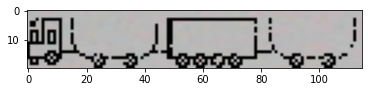
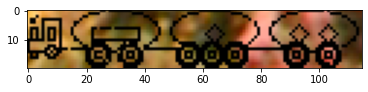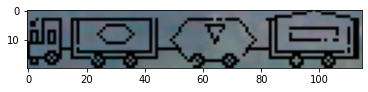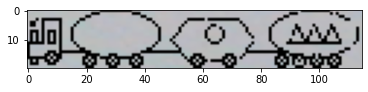

Iremos considerar quatro classes de comboios:

*   EmptyTrain - todas as carruagens estão vazias;
*   HalfFullTrain - algumas carruagens vazias, mas nem todas;
*   FullTrain - todas as carruagens têm exatamente uma figura;
*   OverloadedTrain - não há carruagens vazias e há pelo menos uma carruagem que tem mais do que uma figura.



In [183]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import random

In [184]:
def plot_loss_acc(hist):
  plt.figure()
  plt.plot(hist.history['loss'], label='train_loss')
  plt.plot(hist.history['val_loss'], label='val_loss')
  plt.plot(hist.history['accuracy'], label='train_acc')
  plt.plot(hist.history['val_accuracy'], label='val_acc')
  plt.title('Training Loss and Accuracy')
  plt.xlabel('Epoch #')
  plt.ylabel('Loss/Accuracy')
  plt.margins(x=0)
  plt.margins(y=0)
  plt.legend()
  plt.show()

def print_loss_acc(hist):
  dados_finais_de_treino=[(l,hist.history[l][-1]) for l in hist.history]
  print(dados_finais_de_treino)


O seguinte código permite ler e preparar o conjunto de treino e validação:

In [185]:
def _preprocess_images(images):
  # Scale the raw pixel intesities to the range [-1,1]
  images = images / 127.5 # 255/2
  images = images - 1.0
  images.astype(np.float32)
  return images

# Start by loading the training dataset
# The dataset is made of pictures and their labels (EmptyTrain, HalfFullTrain, FullTrain, OverloadedTrain)
training_data_labels_frame = pd.read_csv('training_trains_labels.csv')
data_labels = training_data_labels_frame.columns.values[1:]
training_data_labels = training_data_labels_frame[data_labels].to_numpy()
original_training_data_images = np.load('training_images.npz')['images']
training_data_images = _preprocess_images(original_training_data_images)

# Load the validation dataset
validation_data_labels_frame = pd.read_csv('validation_trains_labels.csv')
validation_data_labels = validation_data_labels_frame[data_labels].to_numpy()
validation_data_images = _preprocess_images(np.load('validation_images.npz')['images'])

Depois desta leitura e pre-processamento dos dados, os pares **(training_data_images,training_data_labels)** e **(validation_data_images,validation_data_labels)** contêm o conjunto de treino e validação, respetivamente.


Podemos visualizar um pouco mais de informação sobre o dataset usando o seguinte código:

Image data shape: (1200, 20, 115, 3)
Data labels: ['Empty' 'HalfFull' 'Full' 'Overloaded']


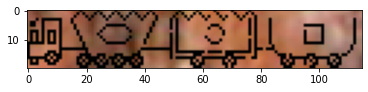

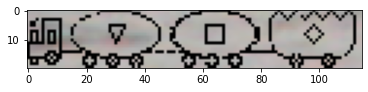

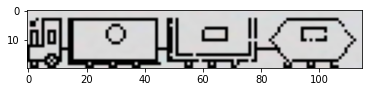

In [186]:
# Lets explore our training dataset
# Print the shape of the training images (#images, height, width, #channels)
# Note: Each channel represents one of the RGB color values
print('Image data shape:', training_data_images.shape)

# Print out labels
print('Data labels:', data_labels)

# Visualize a few images from the training dataset
for i in range(3):
  plt.imshow(random.choice(original_training_data_images))
  plt.show()

In [187]:
def _print_predictions_example(model,file_name):
  test_data_images = _preprocess_images(np.load(file_name)['images'])
  predictions = np.argmax(model.predict(test_data_images), axis=-1)
  print(predictions)

def _visualize_predictions_example(model,file_name,n):
  test_images=np.load(file_name)['images']
  test_data_images = _preprocess_images(np.load(file_name)['images'])
  predictions = np.argmax(model.predict(test_data_images), axis=-1)
  plt.imshow(test_images[n])
  labels=['Empty','HalfFull', 'Full', 'Overloaded']
  print('A classe prevista é:',labels[predictions[n]])

Como a representação de cada imagem tem o formato 20x115x3, temos de transformar esta representação numa só lista. 

Para tal usamos uma camada *Flatten* no início da rede.

Para problemas mais complexos, como é este o caso, podemos usar o otimizador *Adam*, que é uma versão melhorada do SGD.

**Modelo 1**
*   1 camada escondida (neurónios: 4, ativação: relu)
*   1 camada output (neurónios: 4, ativação: softmax)



In [192]:
keras.backend.clear_session()
model = keras.Sequential([
  keras.layers.Flatten(),
  keras.layers.Dense(10,activation='relu'),
  keras.layers.Dense(4,activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  
hist = model.fit(training_data_images,training_data_labels,validation_split=0.02,epochs=400,batch_size=16)

Epoch 1/400
74/74 [==============================] - 0s 4ms/step - loss: 1.4465 - accuracy: 0.3410 - val_loss: 1.0587 - val_accuracy: 0.5833
Epoch 2/400
74/74 [==============================] - 0s 2ms/step - loss: 0.9497 - accuracy: 0.5842 - val_loss: 0.2788 - val_accuracy: 0.9583
Epoch 3/400
74/74 [==============================] - 0s 2ms/step - loss: 0.7013 - accuracy: 0.7185 - val_loss: 0.2757 - val_accuracy: 0.8750
Epoch 4/400
74/74 [==============================] - 0s 2ms/step - loss: 0.5508 - accuracy: 0.8061 - val_loss: 0.2303 - val_accuracy: 0.9583
Epoch 5/400
74/74 [==============================] - 0s 2ms/step - loss: 0.4484 - accuracy: 0.8503 - val_loss: 0.3113 - val_accuracy: 0.9167
Epoch 6/400
74/74 [==============================] - 0s 2ms/step - loss: 0.4054 - accuracy: 0.8554 - val_loss: 0.2677 - val_accuracy: 0.9167
Epoch 7/400
74/74 [==============================] - 0s 2ms/step - loss: 0.3437 - accuracy: 0.8835 - val_loss: 0.1572 - val_accuracy: 0.9167
Epoch 8/400
7

In [193]:
print_loss_acc(hist)

[('loss', 0.001197976409457624), ('accuracy', 1.0), ('val_loss', 0.2679917514324188), ('val_accuracy', 0.9583333134651184)]


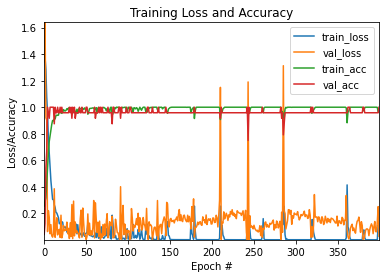

In [162]:
plot_loss_acc(hist)

In [165]:
model.save_weights('model1.h5')

Com este modelo obtivemos uma boa accuracy e um erro baixo. Contudo, temos um erro de validação elevado.

Aumentemos o número de camadas escondidas para averiguarmos se conseguimos melhorar o nosso modelo.

Experimentemos o seguinte modelo:

**Modelo 2**
*   2 camada escondida (neurónios: 4, ativação: relu)
*   1 camada output (neurónios: 4, ativação: linear)



In [167]:
keras.backend.clear_session()
model = keras.Sequential([
  keras.layers.Flatten(),
  keras.layers.Dense(4,activation='relu'),
  keras.layers.Dense(4,activation='relu'),
  keras.layers.Dense(4,activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  
hist = model.fit(training_data_images,training_data_labels,validation_split=0.2,epochs=400,batch_size=16)

Epoch 1/400
60/60 [==============================] - 0s 4ms/step - loss: 1.3420 - accuracy: 0.2958 - val_loss: 1.7060 - val_accuracy: 0.0000e+00
Epoch 2/400
60/60 [==============================] - 0s 2ms/step - loss: 1.2677 - accuracy: 0.3427 - val_loss: 1.9634 - val_accuracy: 0.0000e+00
Epoch 3/400
60/60 [==============================] - 0s 2ms/step - loss: 1.2359 - accuracy: 0.3187 - val_loss: 2.2837 - val_accuracy: 0.0000e+00
Epoch 4/400
60/60 [==============================] - 0s 2ms/step - loss: 1.1913 - accuracy: 0.3938 - val_loss: 2.2058 - val_accuracy: 0.0000e+00
Epoch 5/400
60/60 [==============================] - 0s 2ms/step - loss: 1.1521 - accuracy: 0.4375 - val_loss: 2.1559 - val_accuracy: 0.0000e+00
Epoch 6/400
60/60 [==============================] - 0s 2ms/step - loss: 1.1143 - accuracy: 0.4615 - val_loss: 2.0379 - val_accuracy: 0.0000e+00
Epoch 7/400
60/60 [==============================] - 0s 3ms/step - loss: 1.1137 - accuracy: 0.4802 - val_loss: 1.6926 - val_accura

In [169]:
print_loss_acc(hist)

[('loss', 0.4843061566352844), ('accuracy', 0.7927083373069763), ('val_loss', 3.0256550312042236), ('val_accuracy', 0.0)]


In [96]:
model.save_weights('model2.h5')

Podemos verificar que temos um erro muito baixo e uma accuracy elevada.
Verifiquemos se houve overfitting.

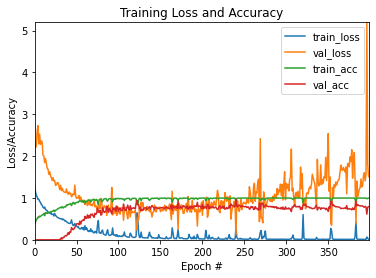

In [139]:
plot_loss_acc(hist)

[3 2 3 3 2 1 3 1 1 2 3 1 2 3 2 1 3 1 2 3 1 3 3 1 2 2 3 3 2 3 1 3 1 1 3 1 3
 3 2 1 1 3 1 1 1 1 2 3 3 3 3 1 3 3 3 1 3 3 3 1 3 3 3 1 1 3 3 3 2 2 2 2 0 3
 2 1 1 2 3 1 3 3 1 1 2 3 1 1 1 3 1 3 3 3 1 3 3 3 3 3 2 2 3 2 1 3 1 3 3 3 3
 1 1 2 1 1 2 1 3 1 1 3 3 2 1 1 3 1 3 1 3 2 2 3 1 3 3 3 1 1 1 1 3 1 2 3 3 3
 1 3 0 1 3 1 3 3 1 1 1 2 2 3 1 2 3 1 2 1 2 3 3 2 2 3 2 1 1 3 2 1 3 1 3 3 1
 3 3 3 2 3 2 3 3 3 2 3 1 3 1 3 3 2 3 0 2 0 2 3 3 3 3 2 1 3 3 2 1 3 1 1 2 1
 3 3 1 1 1 1 3 3 2 3 2 3 2 3 3 3 3 3 3 1 1 2 3 3 2 1 1 1 3 1 3 1 3 2 3 1 3
 3 3 1 3 2 1 1 1 3 3 1 3 1 2 1 2 1 3 1 3 1 1 3 1 1 1 2 3 3 2 1 3 1 1 3 1 3
 3 2 0 3 3 2 1 3 3 1 1 1 3 1 2 3 3 2 3 1 1 1 3 1 1 1 3 3 3 3 1 1 3 2 1 3 3
 1 3 1 3 3 3 1 1 3 2 2 1 3 1 1 3 1 1 1 1 0 3 1 1 3 3 1 1 3 3 2 1 1 3 2 2 2
 3 1 0 3 1 3 2 3 1 1 3 2 1 1 2 2 1 1 3 2 3 1 1 1 1 3 1 3 1 1 2 2 1 3 2 3 3
 3 3 3 3 2 1 3 2 3 2 3 3 3 1 2 3 2 3 1 2 3 3 3 3 3 2 3 2 1 3 3 1 3 1 2 3 1
 2 2 1 3 1 1 1 1 3 3 2 1 2 1 2 2 1 3 1 1 2 1 0 1 0 2 1 2 2 1 1 1 1 1 2 3 1
 0 2 2 1 1 2 2 1 2 1 1 2 

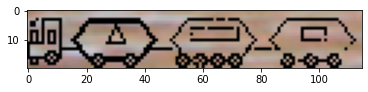

In [198]:
_print_predictions_example(model,'test_images.npz')
_visualize_predictions_example(model, 'test_images.npz',24)